In [44]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from torch.utils.data import DataLoader, TensorDataset
import numpy as np

In [224]:
df = pd.read_csv('dataset/1day.csv')
df = df[['close', 'RSI', 'MACD']]

In [226]:
window_size = 7
df['Target'] = df['close'].pct_change().shift(-1)

# Calculate the mean percentage change over the past 100 entries
df['Target'] = df['Target'].rolling(window=window_size, min_periods=1).mean()

In [227]:
# Drop rows with NaN values introduced by the rolling mean
df = df.dropna()

In [170]:
# Normalize the features
scaler = StandardScaler()
df[['RSI', 'MACD']] = scaler.fit_transform(df[['RSI', 'MACD']])

In [171]:
class PriceChangePredictorLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=1):
        super(PriceChangePredictorLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])  # Only use the output from the last time step
        return out

In [172]:
# Split the data into training and testing sets
X = df[['RSI', 'MACD']].values.astype(float)
y = df['Target'].values.astype(float)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [154]:
# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

In [155]:
# Create DataLoader for batch training
train_data = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)

In [156]:
# Instantiate the model, loss function, and optimizer
input_size = 2  # Number of features (RSI, MACD)
hidden_size = 64  # Number of LSTM units
num_layers = 2  # Number of LSTM layers

model = PriceChangePredictorLSTM(input_size, hidden_size, num_layers)
criterion = nn.MSELoss()  # Mean squared error loss for regression
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [157]:
# Training the model
epochs = 50
for epoch in range(epochs):
    model.train()
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs.unsqueeze(1))  # Add a sequence dimension for LSTM
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

In [158]:
# Evaluate the model
model.eval()
with torch.no_grad():
    predictions = model(X_test_tensor.unsqueeze(1))

In [159]:
# Convert predictions to a numpy array
predicted_values = predictions.view(-1).numpy()

# Combine the actual and predicted values into a DataFrame for comparison
results_df = pd.DataFrame({'Actual': y_test, 'Predicted': predicted_values})

# Print the first few rows of the results
print(results_df.head())

     Actual  Predicted
0  0.000058  -0.000031
1 -0.000024  -0.000061
2  0.000015  -0.000052
3  0.000015  -0.000046
4 -0.000096  -0.000061


In [ ]:
# Save the trained model
torch.save(model.state_dict(), '5_min_final.pth')

## Loading the saved model and using it for predictions

In [228]:
class PriceChangePredictorLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=1):
        super(PriceChangePredictorLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])  # Only use the output from the last time step
        return out

In [240]:
input_size = 2  # Number of features (RSI, MACD)
hidden_size = 64  # Number of LSTM units
num_layers = 4  # Number of LSTM layers

# Define the model architecture
loaded_model = PriceChangePredictorLSTM(input_size, hidden_size, num_layers)

# Load the trained weights
loaded_model.load_state_dict(torch.load('model/1_day_final.pth'))

# Set the model in evaluation mode
loaded_model.eval()

PriceChangePredictorLSTM(
  (lstm): LSTM(2, 64, num_layers=4, batch_first=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)

In [241]:
custom_rsi = df['RSI'].iloc[-1]
custom_macd = df['MACD'].iloc[-1]
actual_prediction = df['Target'].iloc[-1]
custom_rsi, custom_macd, actual_prediction

(-0.476366488736512, -0.3846444281395827, -9.580939994293287e-05)

In [242]:
# Example custom data (replace this with your own data)
custom_data = torch.tensor([[custom_rsi, custom_macd]], dtype=torch.float32)

In [243]:
with torch.no_grad():
    custom_prediction = loaded_model(custom_data.unsqueeze(0))

In [244]:
# Convert the predicted values to a NumPy array
custom_prediction_np = custom_prediction.view(-1).numpy()

# Print the predicted values
print("Predicted Price Change:", custom_prediction_np[0])

Predicted Price Change: -0.00064910576


### Saving the predictions in dataframe

In [245]:
scaler = StandardScaler()
df[['RSI', 'MACD']] = scaler.fit_transform(df[['RSI', 'MACD']])

In [246]:
# Convert the DataFrame to PyTorch tensor
data_tensor = torch.tensor(df[['RSI', 'MACD']].values, dtype=torch.float32)

In [247]:
# Make predictions
with torch.no_grad():
    predictions = loaded_model(data_tensor.unsqueeze(1))

In [248]:
predictions.view(-1).numpy()

array([ 0.00261184, -0.00275633, -0.00326615, ...,  0.0040455 ,
        0.00135113, -0.00064911], dtype=float32)

In [249]:
# Extract and save the predicted values back to the DataFrame
df['Predictions'] = predictions.view(-1).numpy()

# Print or further process the DataFrame with predicted values
print(df.head())

       close       RSI      MACD    Target  Predictions
0  785.57001 -0.072236 -0.417544 -0.051568     0.002612
1  745.06000 -0.779710 -0.405059 -0.028569    -0.002756
2  740.90997 -0.842620 -0.396190 -0.027436    -0.003266
3  722.26001 -1.115737 -0.402666 -0.021765    -0.005117
4  718.83002 -1.164393 -0.408063 -0.025247    -0.005409


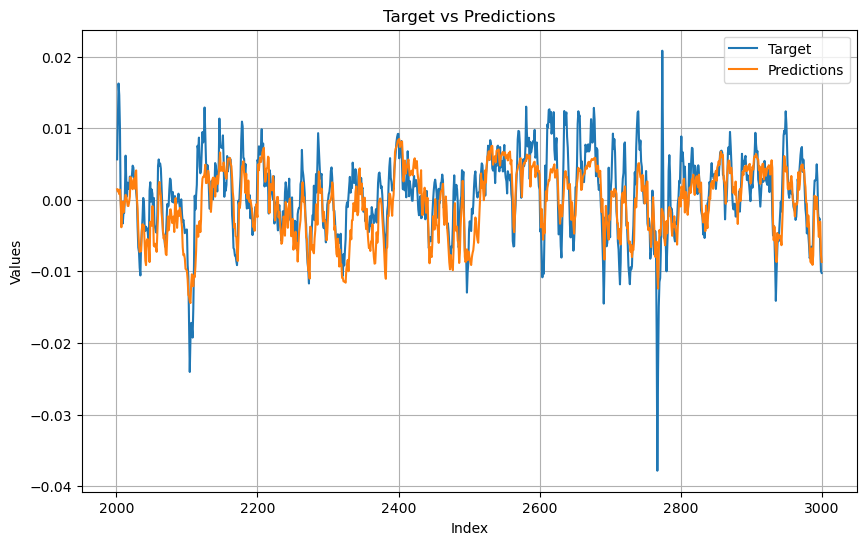

In [250]:
import matplotlib.pyplot as plt
%matplotlib inline

# Assuming df is your DataFrame with columns: 'target' and 'predictions'
# You can modify these column names based on your actual DataFrame

# Plot the target and predictions in a line chart
plt.figure(figsize=(10, 6))

plt.plot(df['Target'][2001:3001], label='Target')
plt.plot(df['Predictions'][2001:3001], label='Predictions')

plt.title('Target vs Predictions')
plt.xlabel('Index')
plt.ylabel('Values')
plt.legend()
plt.grid(True)
plt.show()

### Checking model for 15 min dataset

In [ ]:
df = pd.read_csv('dataset/15min.csv')
df = df[['close', 'RSI', 'MACD']]
window_size = 100
df['Target'] = df['close'].pct_change().shift(-1)
# Calculate the mean percentage change over the past 100 entries
df['Target'] = df['Target'].rolling(window=window_size, min_periods=1).mean()
# Drop rows with NaN values introduced by the rolling mean
df = df.dropna()

In [ ]:
scaler = StandardScaler()
df[['RSI', 'MACD']] = scaler.fit_transform(df[['RSI', 'MACD']])

# Convert the DataFrame to PyTorch tensor
data_tensor = torch.tensor(df[['RSI', 'MACD']].values, dtype=torch.float32)

In [ ]:
# Make predictions
with torch.no_grad():
    predictions = loaded_model(data_tensor.unsqueeze(1))

In [ ]:
predictions.view(-1).numpy()

In [ ]:
# Extract and save the predicted values back to the DataFrame
df['Predictions'] = predictions.view(-1).numpy()

# Print or further process the DataFrame with predicted values
print(df.head())

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

# Assuming df is your DataFrame with columns: 'target' and 'predictions'
# You can modify these column names based on your actual DataFrame

# Plot the target and predictions in a line chart
plt.figure(figsize=(10, 6))

plt.plot(df['Target'][1001:2001], label='Target')
plt.plot(df['Predictions'][1001:2001], label='Predictions')

plt.title('Target vs Predictions')
plt.xlabel('Index')
plt.ylabel('Values')
plt.legend()
plt.grid(True)
plt.show()

For 5 min dataset, window size = 252, <br>
For 15 min dataset, window size = 288, <br>
For 1 hour dataset, window size = 50, <br>
For 1 day dataset, window size = 7,<br>

In [251]:
from sklearn.metrics import mean_squared_error

# Calculate mean squared error
mse = mean_squared_error(df['Target'], df['Predictions'])

print(f'Mean Squared Error: {mse}')

Mean Squared Error: 1.7459000241483367e-05
